# Initial oos exploration

In [1]:
import numpy as np
from graspologic.simulations import rdpg
from graspologic.plot import heatmap, pairplot

### Generate RDPG

Create some augmented graph $A$, which is the adjacency matrix of $\hat{G} = ([n] \cup {v}, E \cup E_v)$, where $E_v$ denotes the set of edges between an out-of-sample vertex $v$ and the vertices of $G$.

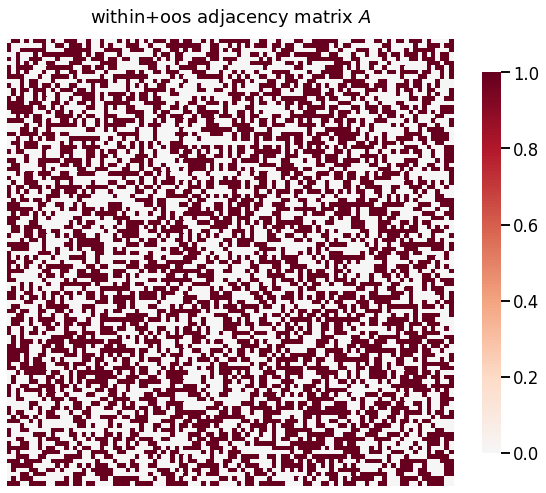

In [2]:
# n is total nodes, n_hat is within-sample nodes
# define parameters
n = 101
n_hat = n-1

# generate matrix
mat = np.full((n, 2), .5)
A = rdpg(mat)
heatmap(A, title="within+oos adjacency matrix $A$");

### Embed everything with ASE

First, we get the base-truth embedding.
Embed $A$, then plot.  
$X$ is the latent position matrix containing both the in-sample and oos nodes.

In [3]:
from numpy.linalg import svd

U, D, V = svd(A)

np.allclose((U**2), (V**2).T)

True

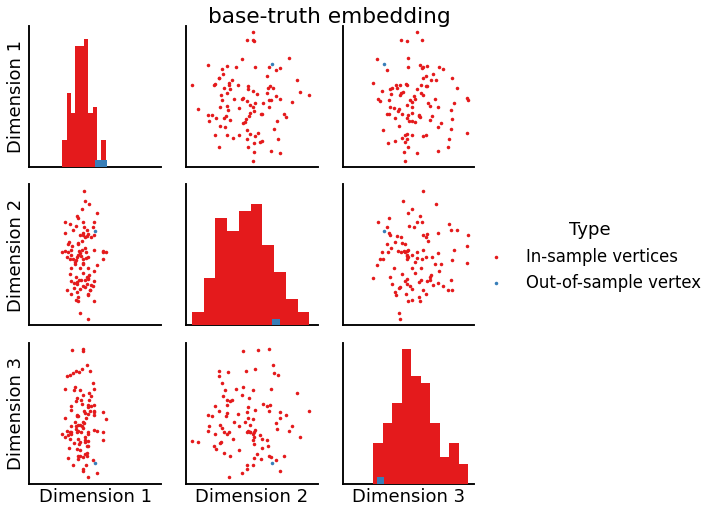

In [4]:
from graspologic.embed import AdjacencySpectralEmbed as ASE
import matplotlib.pyplot as plt
import numpy as np

# get labels
labels = ["In-sample vertices"] * n_hat + ["Out-of-sample vertex"]

# embed both in-sample and oos to get the true latent position for v
d = 3
ase = ASE(n_components=d)
ase.fit(A)
X = ase.latent_left_

# plot
ax1 = pairplot(X, labels=labels, alpha=1, 
              title="base-truth embedding", )

In [5]:
ase.singular_values_

array([50.2501055 ,  9.56232235,  9.08539926])

## LLS

Now, we create a new embedding X_hat, which only contains latent positions of in-sample nodes.  
Also create $\vec{a}$, the out-of-sample node vector.  
The goal is to use only the information in $\hat{X}$ and in $\vec{a}$ to find some embedding $w$ which approximates the true latent position of $\vec{a}$.  
The LLS approach is to embed the oos vertex $v$ (whose vector is $\vec{a}$) as the least-squares solution to $\hat{X}w = \vec{a}$. Meaning, we solve the equation  
$\min{w\in R^d}\sum_{i=1}^n (a_i-\hat{X}_i^Tw)^2$

where $a_i$ denotes the i-th component of the vector $\vec{a}$

#### embed only in-sample with ASE

In [8]:
np.row_stack((a, a))

(2, 100)

In [13]:
a.shape

(100,)

In [14]:
# create in-sample adjacency matrix and an oos vector
A_hat = A[:-1, :-1]
a = A[-1, :-1]  # doesn't contain the 0-value self-loop

# embed
ase = ASE(n_components=d)
ase.fit(A_hat)

# grab latent positions and singular values
X_hat = ase.latent_left_.copy()  # U @ np.diag(np.sqrt(D))
eig_values = ase.singular_values_.copy()  # eigenvalues corresponding to the 2 highest eigenvectors

ase.predict(a[:-1])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 99)

### moore-penrose pseudoinverse equivalence

is `X_hat @ np.diag(1/eig_values)` the moore-penrose pseudoinverse?  
to answer this, figure out if this satisfies the Moore-Penrose conditions

In [7]:
# X_hat is U @ np.diag(np.sqrt(D)), 
# where U is a unitary matrix of eigenvectors and D is a diagonal eigenvalue matrix
pinv = X_hat @ np.diag(1/eig_values)  # so pinv is A^+.T
pinv_np = np.linalg.pinv(X_hat.T)

# same matrix as numpy's pseudoinverse function
np.allclose(pinv_np, pinv)

## moore-penrose conditions:
print(f"AA^+A = A: {np.allclose(X_hat, X_hat @ pinv.T @ X_hat)}")
print(f"A^+AA^+ = A^+: {np.allclose(pinv.T, pinv.T @ X_hat @ pinv.T)}")
print(f"(AA^+)^t = AA^+: {np.allclose((X_hat @ pinv.T).T, X_hat@pinv.T)}")
print(f"(AA^+)^t = AA^+: {np.allclose((pinv.T@X_hat).T, pinv.T@X_hat)}")
# so pinv.T is the pseudoinverse of X_hat

AA^+A = A: True
A^+AA^+ = A^+: True
(AA^+)^t = AA^+: True
(AA^+)^t = AA^+: True


### compute embedding

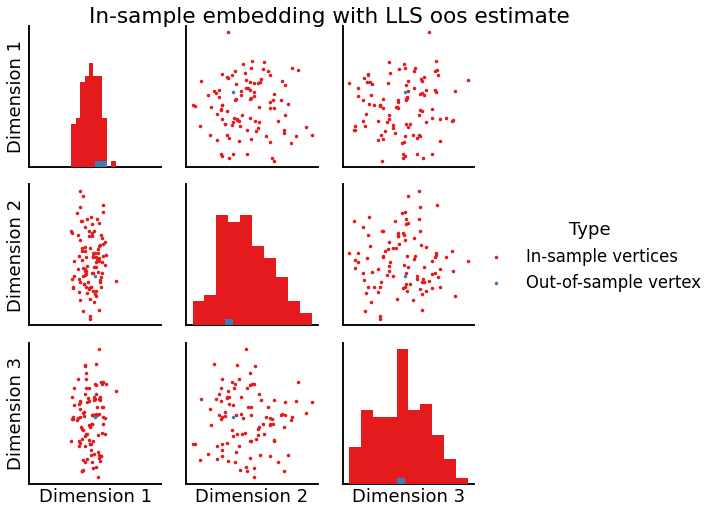

In [8]:
# hayden's code to compute the embedding -- one-liner?
# a: vector for oos node
# X_hat: embedding
# eig_values: eigenvalues for embedding
pseudoinv = X_hat @ np.diag(1/eig_values)
w = a @ pseudoinv  # needed to remove square root I guess?
# w = a @ np.linalg.pinv(X_hat.T)
X_hat_augmented = np.vstack((X_hat, w))

# I clearly fucked up
ax3 = pairplot(X_hat_augmented, labels=labels, alpha=1, 
              title="In-sample embedding with LLS oos estimate")

read up on pseudoinverse  
gives least squares solution  
"moore-penrose pseudoinverse"  
scree plot  
work through 4 properties of pseudoinverse?  

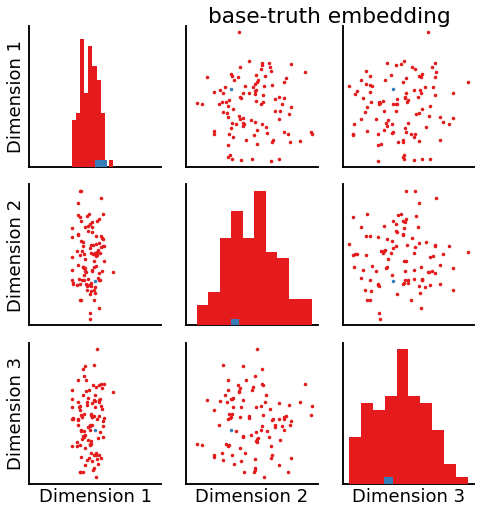

In [9]:
ax = pairplot(X, labels=labels, alpha=1, title="base-truth embedding")
ax._legend.remove()
plt.savefig("../figs/base-truth-embedding.png")
# pairplot(X_hat, title="in-sample embedding", alpha=1, )
# plt.savefig("base-truth-embedding.png")
# ax3 = pairplot(X_hat_augmented, labels=labels, alpha=1, 
#               title="In-sample embedding with LLS oos estimate")


### [Kabsch](https://en.wikipedia.org/wiki/Kabsch_algorithm) algorithm to see if base-truth embedding is the same as LLS oos estimate (minus the OOS point) up to a rotation

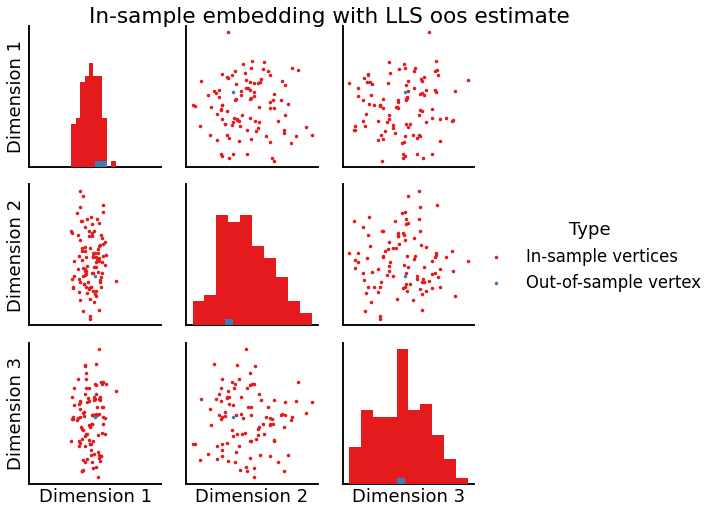

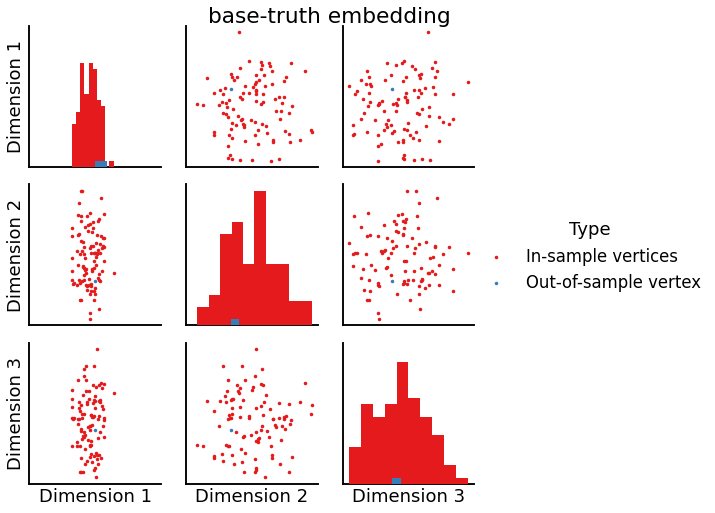

In [10]:
from scipy.spatial.transform.rotation import Rotation

X_hat.shape
X[:-1]

R, *_ = Rotation.align_vectors(X_hat, X[:-1])
X_rot = R.apply(X[:-1])
X_rot = np.vstack((X_rot, R.apply(X[-1])))

pairplot(X_hat_augmented, labels=labels, alpha=1, 
              title="In-sample embedding with LLS oos estimate")

ax = pairplot(X_rot, labels=labels, alpha=1, title="base-truth embedding")